## Default on Credit Card Payment


The purpose of this project is to develop a predictive model that can be used to help the organizations use their data to make better decisions. This is achieved by applying classification techniques to organizations’ data source to make the predictions. A predictive analytics application allows the organization to identify the risks and address them in real time to reach better outcomes. For example, when a customer asks to apply for a new credit card or increase their monthly credit balance, it is necessary for the bank to analyze available data related to that customer before making the decision.


### Data


The Dataset used is **Default of Credit Card Clients**.The dataset contains information on default payments, demographic factors, credit data, history of payments, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.



The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) at the UCI Machine Learning Repository.

In [1]:
#load necessary liabraries
# regex
import re

#data explore
import numpy as np
np.random.seed(1333)

#support for reading excel files
import xlrd

# dataframes in python
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

In [3]:
df = pd.read_excel('./data/default of credit card clients.xls', sheetname='Data',skiprows=1)
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Data Description

#### **Explanatory and Response Variables **

##### Explanatory Variables

**limit_bal **: Amount of the given credit (NT dollar)

**sex **: Gender (1 = male; 2 = female)

**education ** : Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

**marriage **: Marital status (1 = married; 2 = single; 3 = others)
age : Age (years)

**pay_1 - pay_6 ** : History of past payment from Apr2005 - Sept2005

**bill_amt1-bill_amt5 ** : Amount of bill statement(NT dollar) from Apr2005 - Sept 2005

**pay_amt1-pay_amt6 **: Amount of previous payment(NT dollar) from Apr2005 - Sept 2005


##### Response Variables
**default payment next month **: Default payment(1 = yes ; 0 = no)

In this dataset we have 25 attributes including 'id' and it's dropped. (23 variables are Explanatory,one variable is Response)

### Data Wrangling


** Clean up **

All the column names are in uppercase hence we explictly changed to lowercase.Rename the column names when required, In particular, remarkably this dataset misses a colum PAY_1. In the analysis here below we assume that PAY_0 is actually pay_1, to be consider the repayment of the month prior to the month where we calculate the defaulting (which is October 2005, in this particular dataset).Since Column id is not adding much value to the dataset we dropped.



In [4]:
#Change the column names to lower case
df.columns = [x.lower() for x in df.columns]
# Rename Column 
df = df.rename(index=str, columns={"pay_0": "pay_1"})
#Drop Unnecessary Columns 
df = df.drop('id', axis=1)
df.columns

print("No.of Attribute/variables:  {}".format(len(df.columns)))
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))
print("Response variable:       '{}' -> '{}'".format('default payment next month', 'default payment next month'))

No.of Attribute/variables:  24
Explanatory variables:  23
Number of Observations: 30000
Response variable:       'default payment next month' -> 'default payment next month'


** Nominal Variables **

According to Data Dictionary the attribute * education * has broadly divided into four categories i.e Graduate School,University,High School and Others.But when look into data we have 7 categories.For this analysis we have removed extra categories which not mentioned in Data Dictionary  are dropped.

let's make use of categorical features of pandas, by converting default payment next month as 'target', sex, marriage, education, age and the pay_* columns to categories.Create another column as 'age_cat' with 6 bins as [20,30] [30,40][40,50] [50,60] [60,70] [70,80]

In [5]:

print(df.education.value_counts())
#exclude the data related to education categories 5,6 & 0 as its Unknown
df = df[(df.education != 5) & (df.education != 6 ) & (df.education != 0)]
df['education'] = df['education'].astype('category').cat.rename_categories(['Graduate School', 'University', 'High School', 'Others'])
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)
df['target'] = df['default payment next month'].astype('category')
#df.dtypes


2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: education, dtype: int64


#### Exploratory Data Analysis

##### Explore Defaulting


We want to predict defaulting,but before digging into deeper Let's think in broader perspective by looking into payment delays and credit card limit.    

** Payment Delays **

Dipict all payment delays 

In [6]:
#Extract the payment delays columns using regular expressions and display top 10 records
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
df[pay_status_columns].head(6)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0


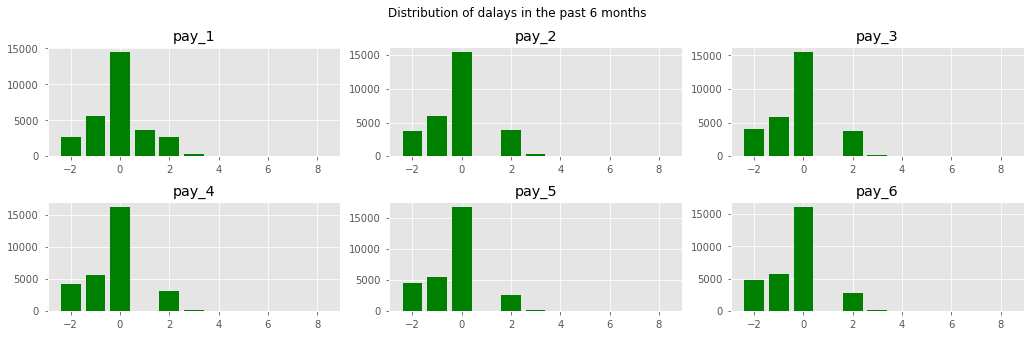

In [7]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of dalays in the past 6 months')

for i in range(len(pay_status_columns)):
    #row,col for axis
    row,col = int(i/3), i%3
    #each payment delays distinct values are stored in respective 
    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index,d,color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

 The measurement scale for the repayment status is either negative or 0 means upfront or on par.If repayment status is positive means running behind payments.If positive repayment status is very high indicates risk of future defaulter.


##### Higher Dimentionality Visuallizations - imshow

 **Check the Correlation between credit limit,bill amount and payment status **

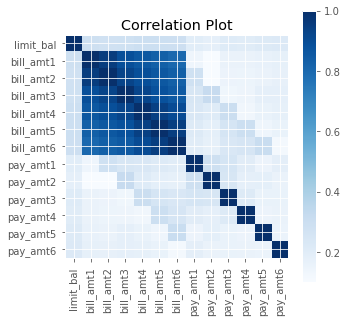

In [8]:
# extract limit_bal,bill_amt and pay_amt
im_corr = df.ix[:,[0,11,12,13,14,15,16,17,18,19,20,21,22]] #.corr()
plt.figure()

plt.imshow(im_corr.corr(), cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(im_corr.columns))]
plt.xticks(tick_marks,im_corr.columns,rotation='vertical')
plt.yticks(tick_marks,im_corr.columns)
plt.title('Correlation Plot')
plt.show()

The above plot shows a strong correlation between credit limit and billing amounts from BILL_AMT6(April 2005)  to  BILL_AMT1 ( Sep. 2005) and no correlation between credit limit and payment status during that period.


** Credit Limit and Payments ** 


In [9]:
# bill columns
pattern_amt = re.compile("^bill_amt[0-9]+$")
bill_columns = [ x for x in df.columns if (pattern_amt.match(x))]
print("************************************************************************")
print('Amount of Bill Stament from April to September 2005 (bill_amt6 to bill_amt1)')
print("************************************************************************")
print(df[bill_columns].describe())
print("************************************************************************")

print("Amount of the given credit (NT dollar) : Summary Statistics ")
print("************************************************************************")
df['limit_bal'].describe()

************************************************************************
Amount of Bill Stament from April to September 2005 (bill_amt6 to bill_amt1)
************************************************************************
           bill_amt1      bill_amt2     bill_amt3      bill_amt4  \
count   29655.000000   29655.000000  2.965500e+04   29655.000000   
mean    50901.789850   48896.707166  4.675304e+04   43078.641612   
std     73322.807546   70878.090337  6.907969e+04   64153.942066   
min   -165580.000000  -69777.000000 -1.572640e+05 -170000.000000   
25%      3519.000000    2960.000000  2.642000e+03    2318.500000   
50%     22221.000000   21029.000000  2.002300e+04   19000.000000   
75%     66505.500000   63391.500000  5.975150e+04   54063.500000   
max    964511.000000  983931.000000  1.664089e+06  891586.000000   

           bill_amt5      bill_amt6  
count   29655.000000   29655.000000  
mean    40194.544259   38818.310774  
std     60660.052976   59481.439973  
min    -8133

count      29655.000000
mean      167487.562974
std       129882.968232
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

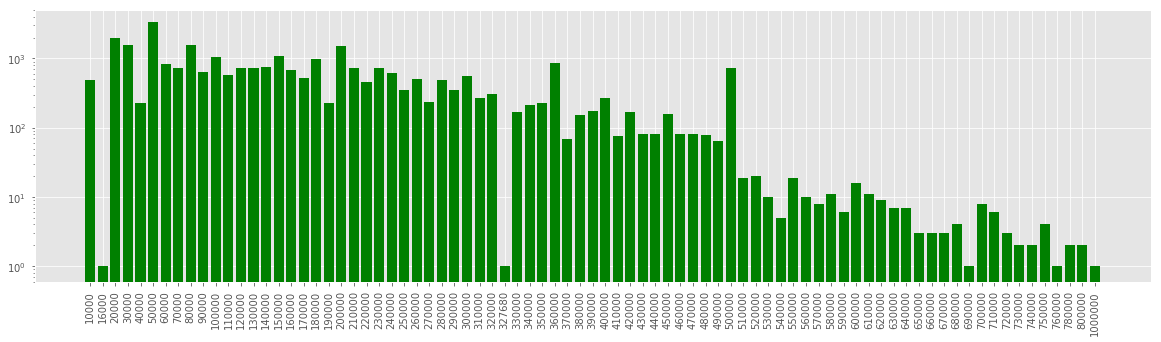

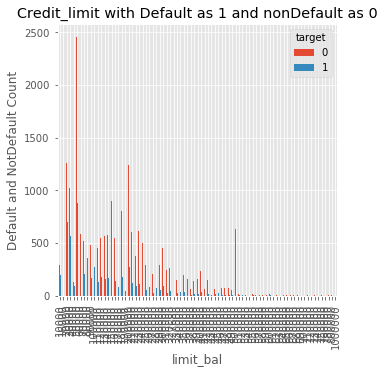

In [10]:
# Credit limit balance
fig = plt.figure()
fig.set_size_inches(20,5)
ax = fig.add_subplot(111)

d = df.groupby(['limit_bal']).size()
ax.set_yscale("log")
ax.set_xticks(np.arange(len(d)))
ax.set_xticklabels(['%d' % i for i in d.index], rotation='vertical')
p = ax.bar(np.arange(len(d)), d,color='green')


# Credit limit balance with default and without default
fig = plt.figure()
fig.set_size_inches(5,5)
e =df.groupby(['limit_bal','target']).size()
e.unstack(level=1).plot(kind='bar')
ax.set_xticks(np.arange(len(d)))
plt.ylabel("Default and NotDefault Count")
plt.title("Credit_limit with Default as 1 and nonDefault as 0")


Default rate is high with credit card limit 50000,20000,30000,80000 and so on.

** Dive deep into defaulting **

By asking questions  
    1.How many observations do we have in our dataset?
    
    2.Is there any relationship with various demographs?

 Payments : Default= 1 
target
0    23045
1     6610
dtype: int64
defaulting accounts are 22.289664474793458% out of 29655 observations


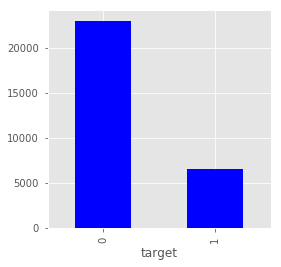

In [11]:
fig = plt.figure()
fig.set_size_inches(4,4)
#groupby target column to get default and not default count
d = df.groupby(['target']).size()
print(" Payments : Default= 1 ")
print(d)
print("defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
df.groupby(['target']).size().plot.bar(color='blue')

### Absolute Statisctics

For Various Demographics

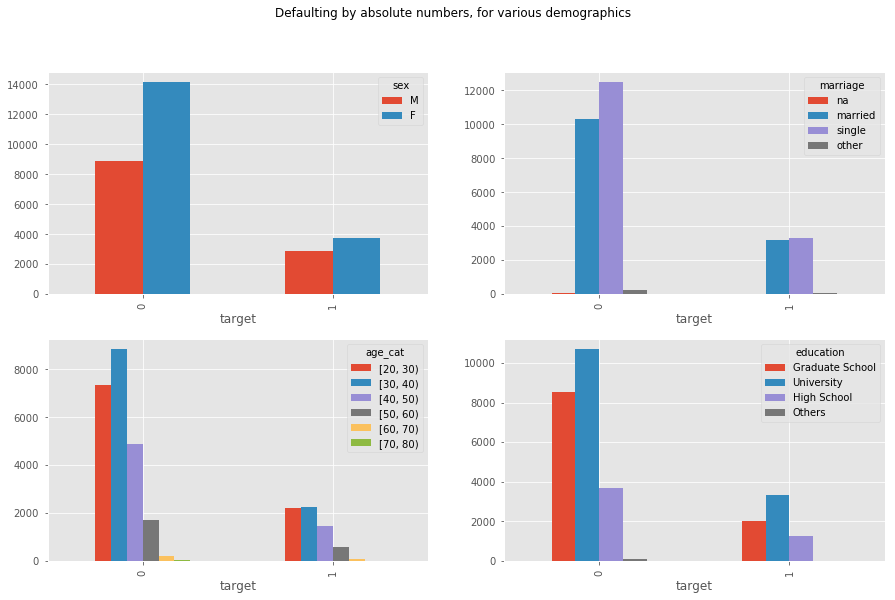

In [12]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,9)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0,0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0,1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1,0])

d = df.groupby(['target', 'education']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1,1])

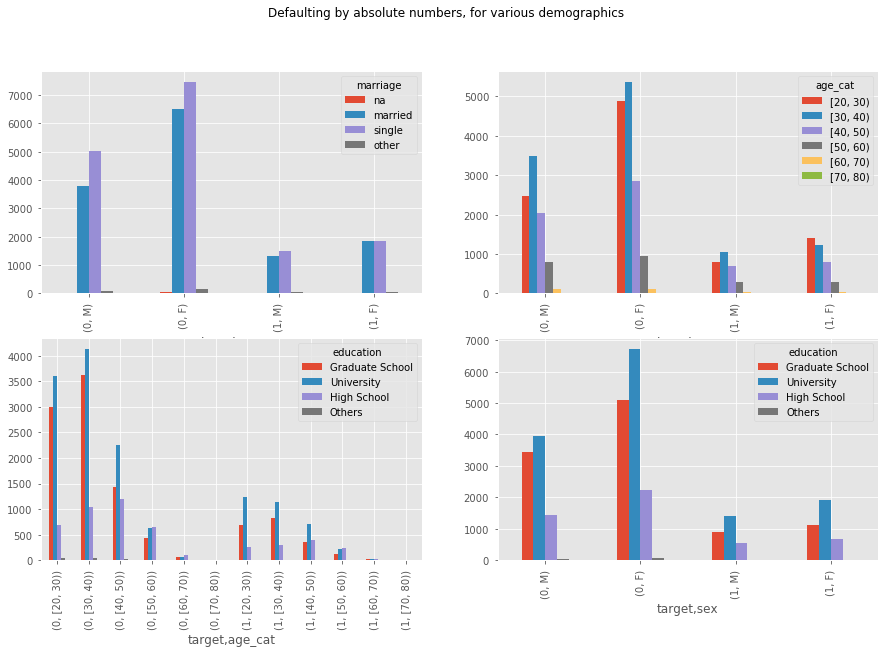

In [13]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,9)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['target', 'sex','marriage']).size()
p = d.unstack(level=2).plot(kind='bar', ax=ax[0,0])

d = df.groupby(['target', 'sex','age_cat']).size()
p = d.unstack(level=2).plot(kind='bar', ax=ax[0,1])

d = df.groupby(['target', 'age_cat','education']).size()
p = d.unstack(level=2).plot(kind='bar', ax=ax[1,0])

d = df.groupby(['target','sex' ,'education']).size()
p = d.unstack(level=2).plot(kind='bar', ax=ax[1,1])

#### Statistics relative to the population



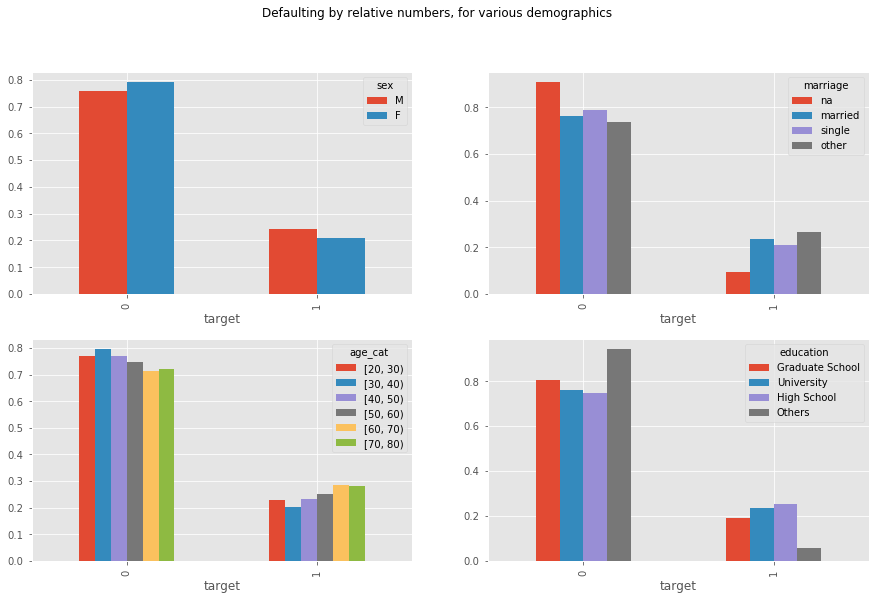

In [14]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15,9)
fig.suptitle('Defaulting by relative numbers, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0,0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0,1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1,0])

d = df.groupby(['target', 'education']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1,1])


**  Calculating monthly default rate from April - September in 2005**



RangeIndex(start=0, stop=1, step=1)


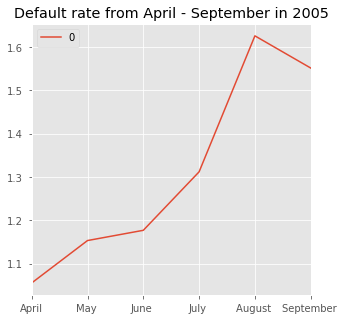

In [15]:
months_names = ['April' ,'May ','June ','July ','August ','September ']
p =[]
a=len(df[df.pay_6 > 2])/len(df)
p.append(a*100)
a=len(df[df.pay_5 > 2])/len(df)
p.append(a*100)
a=len(df[df.pay_4 > 2])/len(df)
p.append(a*100)
a=len(df[df.pay_3 > 2])/len(df)
p.append(a*100)
a=len(df[df.pay_2 > 2])/len(df)
p.append(a*100)
a=len(df[df.pay_1 > 2])/len(df)
p.append(a*100)

default_rate = pd.DataFrame(p,index = months_names)
print(default_rate.columns)
fig = plt.figure(figsize=(4,4))
#ax.set_xticklabels(rotation='vertical')
default_rate.plot(kind='line')
plt.title("Default rate from April - September in 2005")

The graph shows that the default rate is increasing from April to August and then there is dip in Sepetember 2005.

#### Transforming

** Feature selection**

Construct two matrices one act as outcome and other as predictor.Next, use unsupervized machine learning **Dimentationality Reduction ** methods like PCA.



In [16]:
# Construct two design matrices given a formula_like and data.On the other hand it returns 
# first matrix is the `out come` and second is the `predictor`.

from patsy import dmatrices

def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

formula  = 'target ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

# categorical age and credit limit (binned)
formula += '+' + 'C(age_cat)'

# bill amounts
formula += '+' + '+'.join(selcols('bill_amt'))
#pay_amt
formula += '+' + '+'.join(selcols('pay_amt'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]


In [17]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix,classification_report

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
      
    print("*************** Classification Report****************")
    print(classification_report(y_test, y_test_pred_labels))
    print("******************************************************")
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text,test_text])



### PCA

** Preprocessing ** 
Feature selection is a process in which automatically features are selected which contributes most to the prediction variable.The question next comes into our mind is how many components?Initially start with any no. of components of your choice and fit a model.Next plot no.of components Vs cumulative variance to get a clear picture.Finally  build a model with appropriate no. of components after transforming.


[ 20.39  32.51  42.16  47.19  51.91  56.3   59.92  63.37  66.61  69.76
  72.89  75.99  78.84  81.62  84.35  87.06  89.5   91.79  93.92  95.51
  96.77  97.58  98.35  98.94  99.35  99.57  99.71  99.84  99.92  99.99 100.
 100.   100.   100.   100.  ]


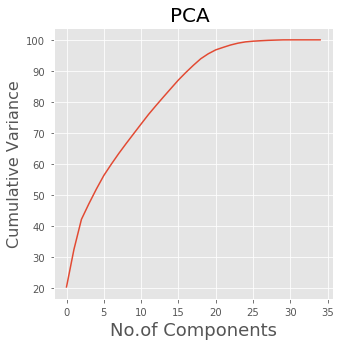

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = scale(X)

pca = PCA(n_components=35)
pca.fit(X)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)
plt.plot(var1)
plt.xlabel('No.of Components',fontsize=18)
plt.title('PCA ',fontsize=20)
plt.ylabel('Cumulative Variance',fontsize=16)


Remarks : By looking at above plot we are taking 29 components into account.

In [19]:
# transform the data
pca = PCA(n_components=29)
pca.fit(X)
X_prep = pca.fit_transform(X)


** Model selection and validation **

Since it's a classification problem we are building following models with confusion matrix ,accuracy and ROC curves. 

    1.Logistic Regression
    2.SVC Linear
    3.SVC rbf
    4.Random Forest
    5.K-NN


In [26]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.3, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


** Logistic Regression **

*************** Classification Report****************
             precision    recall  f1-score   support

        0.0       0.82      0.96      0.88      6886
        1.0       0.68      0.27      0.38      2011

avg / total       0.79      0.81      0.77      8897

******************************************************


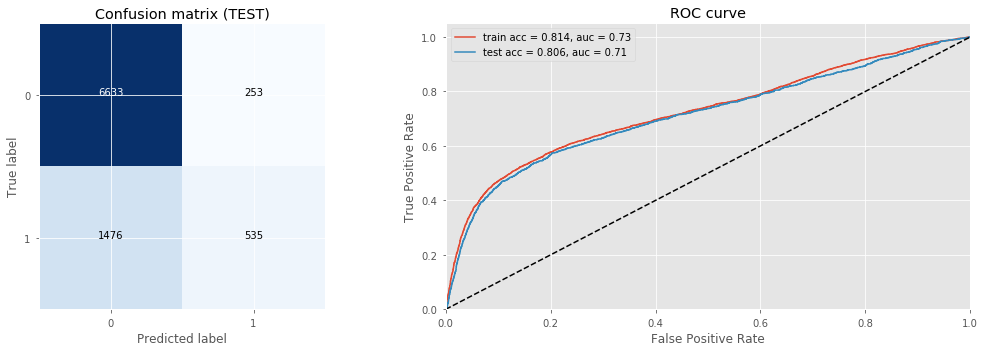

In [27]:
from sklearn import linear_model

# Create logistic regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

y_train_pred = regr.predict_proba(X_train)[:,1]
y_test_pred = regr.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,5)


plot_cm(ax[0],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[1], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()


*************** Classification Report****************
             precision    recall  f1-score   support

        0.0       0.81      0.96      0.88      6886
        1.0       0.67      0.25      0.36      2011

avg / total       0.78      0.80      0.77      8897

******************************************************


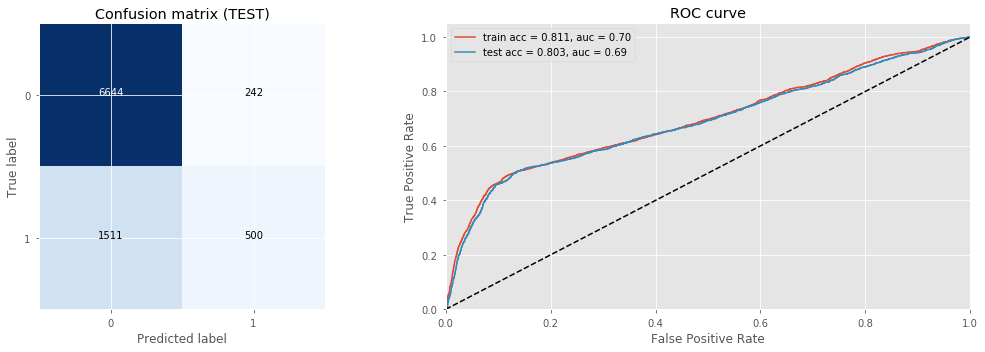

In [28]:
%timeit
from sklearn import svm
linear_svc = svm.SVC(kernel='linear', probability=True)
linear_svc.kernel
linear_svc.fit(X_train,y_train)

y_train_pred = linear_svc.predict_proba(X_train)[:,1]
y_test_pred = linear_svc.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[1], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()


*************** Classification Report****************
             precision    recall  f1-score   support

        0.0       0.83      0.96      0.89      6886
        1.0       0.68      0.32      0.43      2011

avg / total       0.79      0.81      0.78      8897

******************************************************


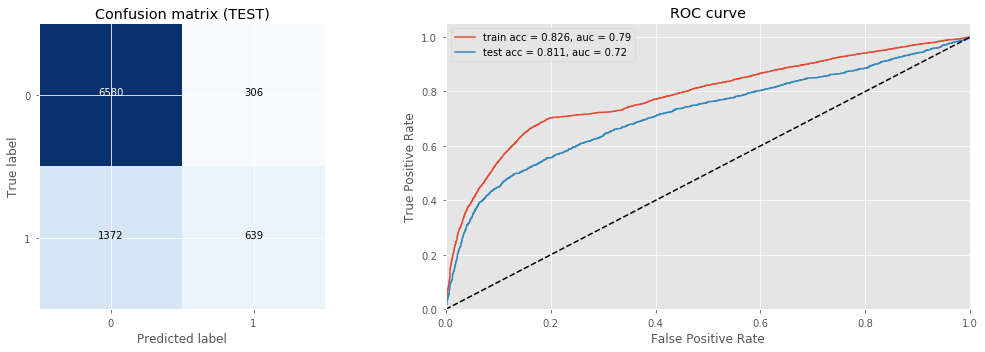

In [29]:
rbf_svc = svm.SVC(kernel='rbf', probability=True)
rbf_svc.kernel
rbf_svc.fit(X_train,y_train)

y_train_pred = rbf_svc.predict_proba(X_train)[:,1]
y_test_pred = rbf_svc.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,5)


plot_cm(ax[0],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[1], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

*************** Classification Report****************
             precision    recall  f1-score   support

        0.0       0.83      0.94      0.88      6886
        1.0       0.64      0.34      0.45      2011

avg / total       0.79      0.81      0.78      8897

******************************************************


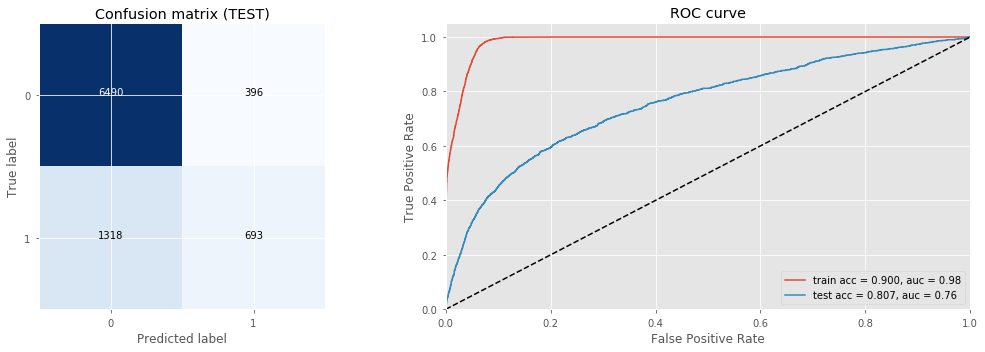

In [31]:
#RFC
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)

# Train the classifier
clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)[:,1]
y_test_pred = clf.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[1], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

*************** Classification Report****************
             precision    recall  f1-score   support

        0.0       0.82      0.95      0.88      6886
        1.0       0.64      0.28      0.39      2011

avg / total       0.78      0.80      0.77      8897

******************************************************


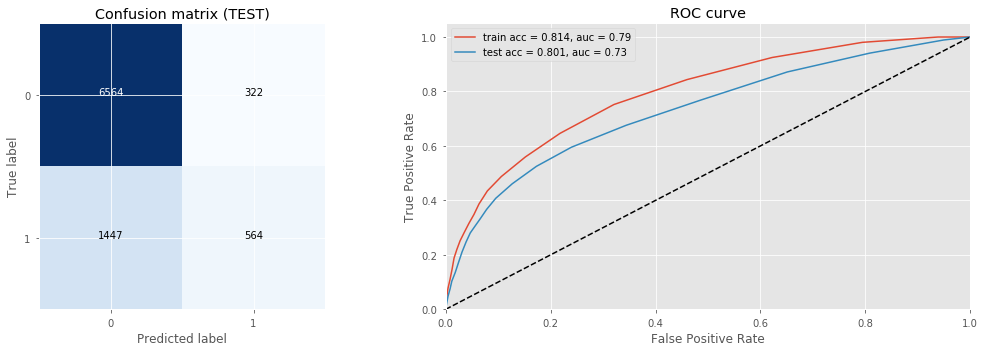

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)    
#pred = knn.predict(X_test)
#accuracy_score(X_test,pred)
y_train_pred = knn.predict_proba(X_train)[:,1]
y_test_pred = knn.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[1], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()


#### Model Evaluation


**Accuracy:**

Proportion of all predictions that are correct.Accuracy is a measurment of how good a model is.

**Precision:**

Proportion of all positive predictions that are correct.Precision is a measure of how many positive predictions were actual positive observations.

**Recall:**

Proportion of all real positive observations that are correct.It is a measure of how many actual positive observations were predicted correctly.

**F1 Score:**

F1 score is an 'average' of both precision and recall.



After creating and training five predictive models, we evaluate them using test data and then create the confusion matrix which consists of four measures: accuracy, sensitivity or recall,f1 and precision.

####   Analysis and Recommendation

In order to identify the customers that would fail to pay the credit card amount duly, the prediction model should not make any wrong predictions on those who are classified into class “no default payment” (0) but actually are in class “default payment” (1). Therefore, the **lower number of false negatives would be preferred**. In this case, **recall would be of higher importance as it reflects the percentage of positive tuples that classifier labeled as negative**. ***Higher recall means the classification model is more likely to identify more clients that have high chance of having a default payment, which could potentially lead to the loss for the bank***.In term of finance, the classification model would help the bank prevent loan loss, improve the performance and maximize the efficiency.


The analysis of different classifying algorithms does help future research in this field.All algorithms have produced an accuracy of about 80 percent.From the above results with respect to this Data Set we can choose RandomForest to be the best as it has the highest recall value.

